In [ ]:
import pandas as pd

import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.utils.np_utils import to_categorical

from keras.layers import concatenate

#from keras.utils import to_categorical

#Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation, Reshape, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.regularizers import l2


In [ ]:
!wget 'https://raw.githubusercontent.com/kalebupatan7/Skin-Cancer-Classification-with-Machine-Learning/main/kaggle.json' 
    

--2023-04-30 00:51:03--  https://raw.githubusercontent.com/kalebupatan7/Skin-Cancer-Classification-with-Machine-Learning/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      67  --.-KB/s    in 0s      

2023-04-30 00:51:03 (2.68 MB/s) - ‘kaggle.json’ saved [67/67]



In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
import kaggle

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:19<00:00, 42.3MB/s]
100% 5.20G/5.20G [02:19<00:00, 40.0MB/s]


In [ ]:
import zipfile
import os
zip_ref = zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall()
zip_ref.close()
os.unlink('skin-cancer-mnist-ham10000.zip')

In [ ]:
li = ['hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_28_28_L.csv']
for i in li:
    os.unlink(i)


!rm -rf ham10000_images_part_1
!rm -rf ham10000_images_part_2

In [ ]:
os.listdir()

['.config',
 'kaggle.json',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_1',
 'sample_data']

In [ ]:
skin_dataset = pd.read_csv('HAM10000_metadata.csv')
skin_dataset

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


male       5406
female     4552
unknown      57
Name: sex, dtype: int64

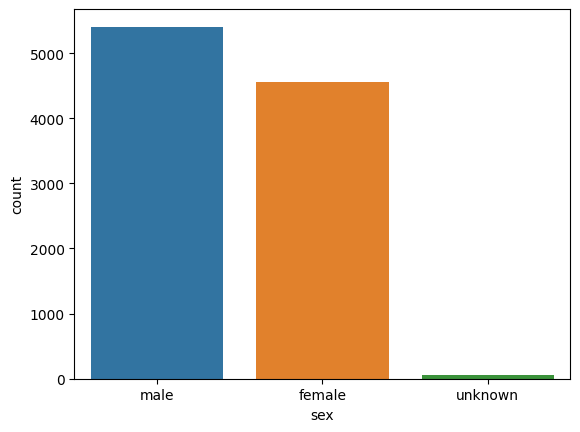

In [ ]:
import seaborn as sb
skin_dataset['sex']
sb.countplot(x=skin_dataset['sex'])
skin_dataset['sex'].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: age, dtype: int64

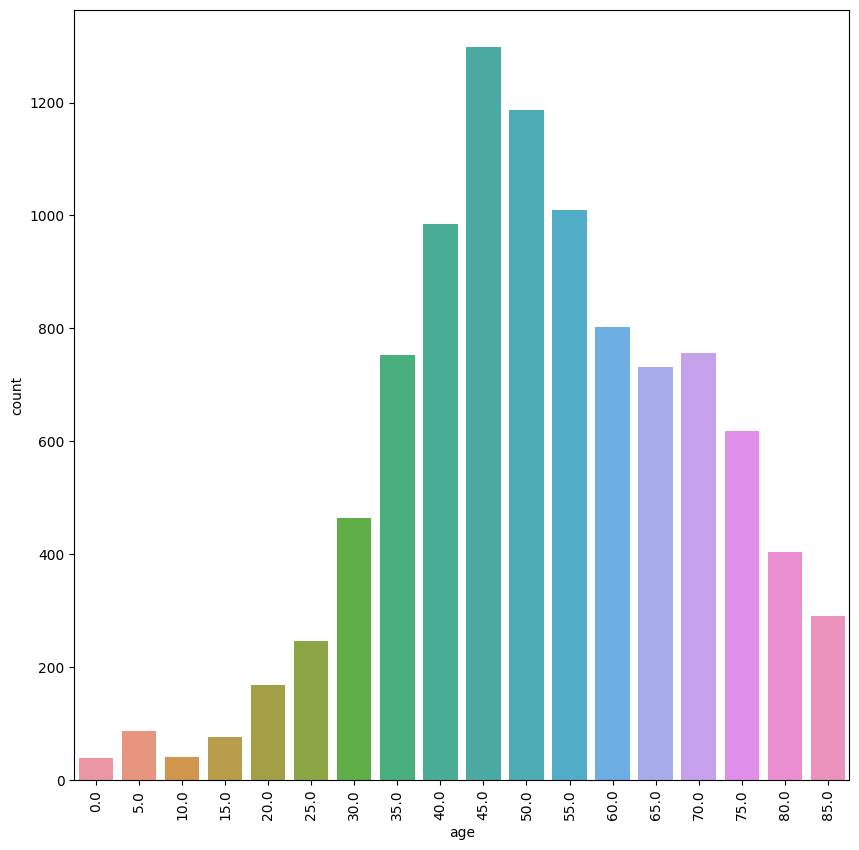

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
sb.countplot(x=skin_dataset['age'])
skin_dataset['age'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

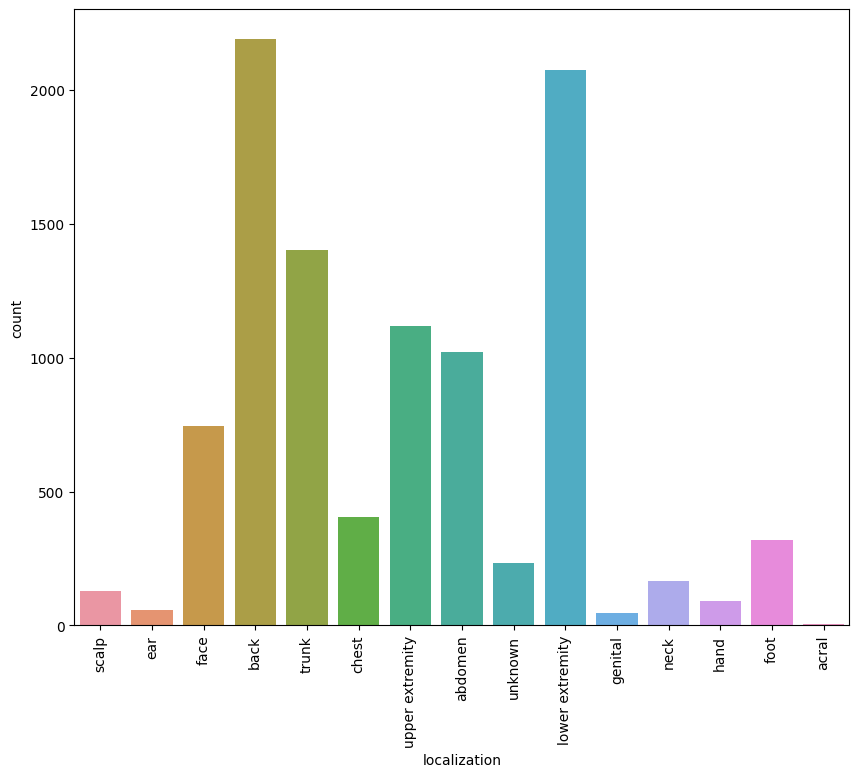

In [ ]:
plt.figure(figsize=(10,8))
sb.countplot(x=skin_dataset['localization'])
plt.xticks(rotation=90)
skin_dataset['localization'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

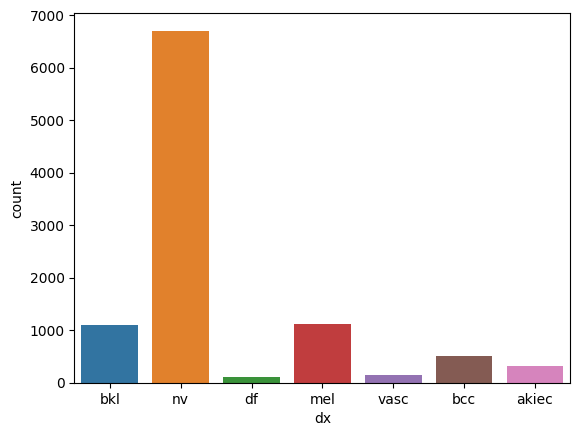

In [ ]:
sb.countplot(x=skin_dataset['dx'])
skin_dataset['dx'].value_counts()

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

skin_dataset['cell_type'] = skin_dataset['dx'].map(lesion_type_dict)

In [ ]:
skin_dataset['cell_type_idx'] = pd.Categorical(skin_dataset['cell_type']).codes

In [ ]:
skin_dataset.isna().sum().sort_values(ascending=False)

age              57
lesion_id         0
image_id          0
dx                0
dx_type           0
sex               0
localization      0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
print(skin_dataset['age'].mean())
print(skin_dataset['age'].median())

51.863828077927295
50.0


In [ ]:
skin_dataset['age'].fillna(skin_dataset['age'].mean(),inplace=True)

<Axes: xlabel='age', ylabel='Density'>

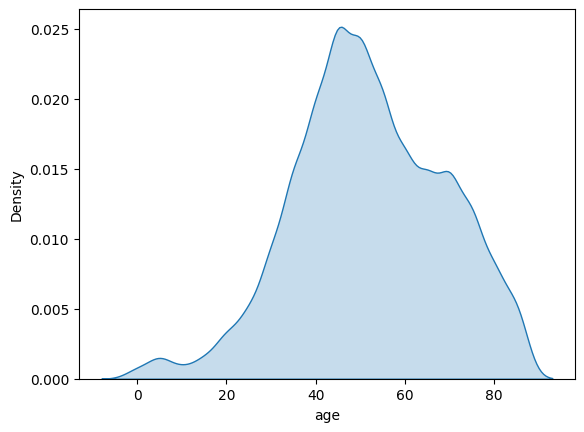

In [ ]:
sb.kdeplot(skin_dataset['age'],fill=True)

In [ ]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
skin_dataset['path'] = skin_dataset['image_id'].map(image_path.get)
skin_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
image_example = np.asarray(pil_image.open(skin_dataset['path'][0]))

image_example.shape

(450, 600, 3)

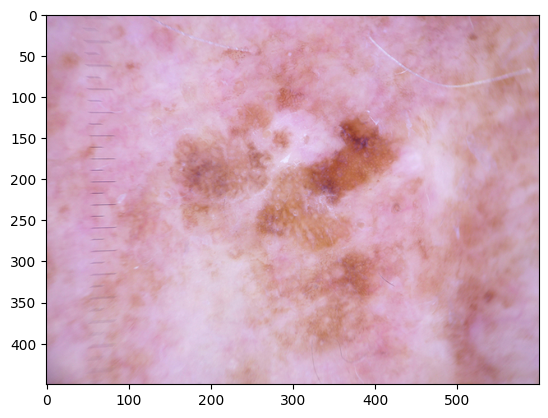

In [ ]:
plt.imshow(image_example)

In [ ]:
skin_dataset['image'] = skin_dataset['path'].map(lambda x: np.asarray(pil_image.open(x).resize((90,120)))) 

In [ ]:
skin_dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 154, 195], [192, 155, 197], [191, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 24], [25, 14, 29], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[187, 129, 138], [192, 135, 149], [196, 140,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 18], [26, 13, 22], [39, 23, 32], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2/ISIC_0031633.jpg,"[[[132, 89, 112], [147, 102, 125], [161, 117, ..."


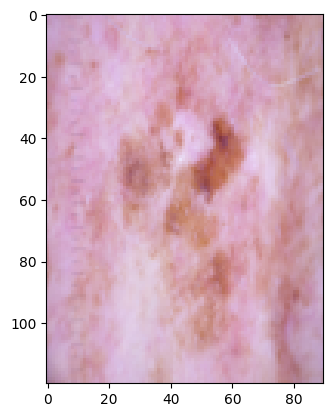

In [ ]:
plt.imshow(skin_dataset['image'][0])

#### we can see that only a few of the features are dumped, however, almost all the features are sitll preserved

## Data preparation and modelling

In [ ]:
features = skin_dataset.drop(['cell_type_idx'],axis=1)
features.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 154, 195], [192, 155, 197], [191, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 24], [25, 14, 29], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[187, 129, 138], [192, 135, 149], [196, 140,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 18], [26, 13, 22], [39, 23, 32], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,HAM10000_images_part_2/ISIC_0031633.jpg,"[[[132, 89, 112], [147, 102, 125], [161, 117, ..."


In [ ]:

target = skin_dataset['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)


In [ ]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [ ]:
print(x_train.shape)
print(x_test.shape)

(9914, 120, 90, 3)
(101, 120, 90, 3)


In [ ]:
train_mean = x_train.mean()
print(train_mean)
train_std = x_train.std()
print(train_std)
test_mean = x_test.mean()
print(test_mean)
test_std = x_test.std()
print(test_std)

159.8214209516658
46.45621540089119
159.43820865419875
45.29889428224181


In [ ]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [ ]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [ ]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [ ]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [ ]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


In [ ]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="conv1", input_shape=input_shape)) 
model.add(BatchNormalization(name="Norm1"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) 
model.add(BatchNormalization(name="Norm2"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) 
model.add(BatchNormalization(name="Norm3"))
model.add(MaxPooling2D(pool_size = (2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',name="conv4")) 
model.add(BatchNormalization(name="Norm4"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv5")) 
model.add(BatchNormalization(name="Norm5"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv6")) 
model.add(BatchNormalization(name="Norm6"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv7")) 
model.add(BatchNormalization(name="Norm7"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv8")) 
model.add(BatchNormalization(name="Norm8"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv9")) 
model.add(BatchNormalization(name="Norm9"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.20))

model.add(Conv2D(7,(1,1),name="conv10",activation="relu")) 
model.add(BatchNormalization(name="Norm10"))
model.add(Conv2D(7,kernel_size=(6,9),name="conv11"))
model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.35, 
                                            min_lr=0.000001)

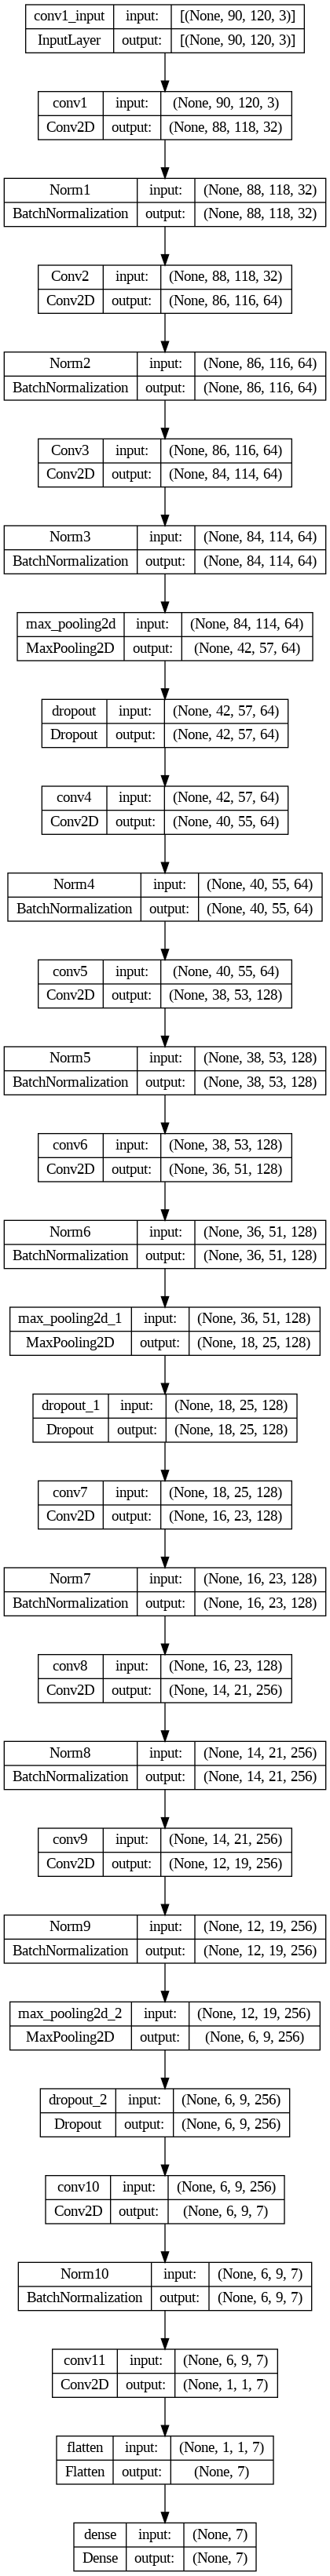

In [ ]:
#We can do later
plot_model(model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='simple_model_plot.png')

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1 
)

epochs = 30
batch_size = 32
model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
263/263 [==============================] - 55s 138ms/step - loss: 1.0680 - accuracy: 0.6409 - val_loss: 1.0958 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 2/30
263/263 [==============================] - 33s 125ms/step - loss: 0.8850 - accuracy: 0.6798 - val_loss: 0.9911 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 3/30
263/263 [==============================] - 34s 130ms/step - loss: 0.8514 - accuracy: 0.6936 - val_loss: 0.8776 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 4/30
263/263 [==============================] - 33s 124ms/step - loss: 0.8170 - accuracy: 0.6997 - val_loss: 0.9051 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 5/30
263/263 [==============================] - 34s 129ms/step - loss: 0.7843 - accuracy: 0.7135 - val_loss: 0.8572 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 6/30
263/263 [==============================] - 33s 125ms/step - loss: 0.7704 - accuracy: 0.7191 - val_loss: 0.9796 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 7/30
263/263 [==============================] 

In [ ]:
def report(model):
    # classification report
    Y_pred = model.predict(x_test)
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    Y_true = np.argmax(y_test,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(Y_true, Y_pred_classes))

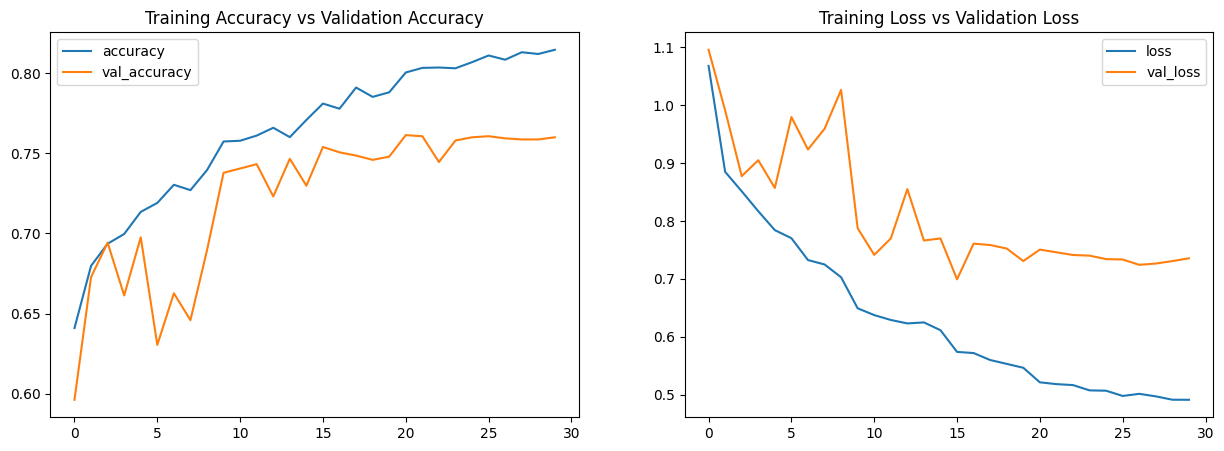

In [ ]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_accuracy")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  76.1425
4/4 [==============================] - 1s 121ms/step


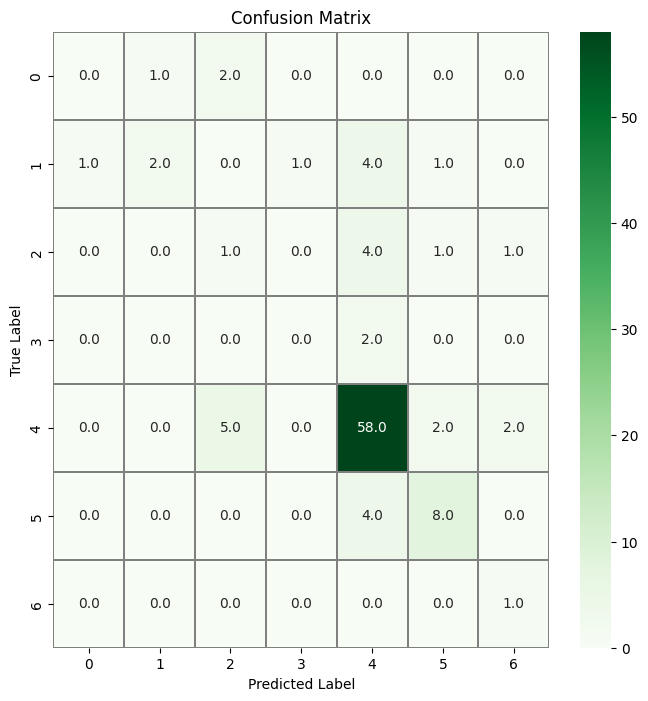

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.22      0.33         9
           2       0.12      0.14      0.13         7
           3       0.00      0.00      0.00         2
           4       0.81      0.87      0.83        67
           5       0.67      0.67      0.67        12
           6       0.25      1.00      0.40         1

    accuracy                           0.69       101
   macro avg       0.36      0.41      0.34       101
weighted avg       0.68      0.69      0.68       101



In [ ]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))
report(model)

Original Shape of image is :  (372, 662, 3)


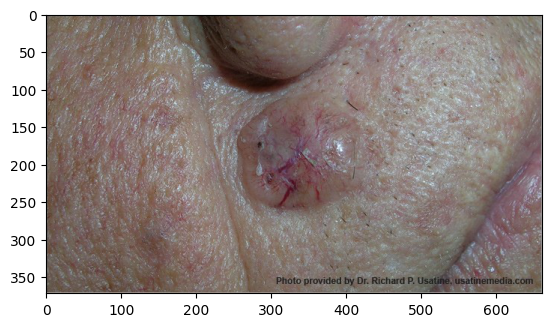

In [ ]:
import urllib

url="https://www.cancer.org/content/dam/cancer-org/images/galleries/skin-cancer-images/cancer-basal-cell-carcinoma-01-restricted.jpg/jcr:content/renditions/cq5dam.web.1280.1280.jpeg"
urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [ ]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [ ]:
prediction_class = model.predict(test_image)
maxval = np.max(prediction_class[0])
print(np.where(prediction_class[0] == maxval)[0])
lesion_type_dict[lesion_classes_dict[np.where(prediction_class[0] == maxval)[0][0]]]

1/1 [==============================] - 1s 692ms/step
[0 3 6]


'Melanocytic nevi'

**VGG16**

In [ ]:


# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def VGG16_L2_dropout():

    model = Sequential()

    model.add(Conv2D(input_shape=(90, 120, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))

    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="vgg16"))

    model.add(Dropout(0.25))

    model.add(Flatten(name="flatten"))

    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001), name='fc1'))

    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001), name="fc2"))

    model.add(Dropout(0.5))

    model.add(Dense(7, activation="sigmoid", name="output"))

    return model


In [ ]:
input_shape = (90, 120, 3)
num_classes = 7

model2 = VGG16_L2_dropout()
model2.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

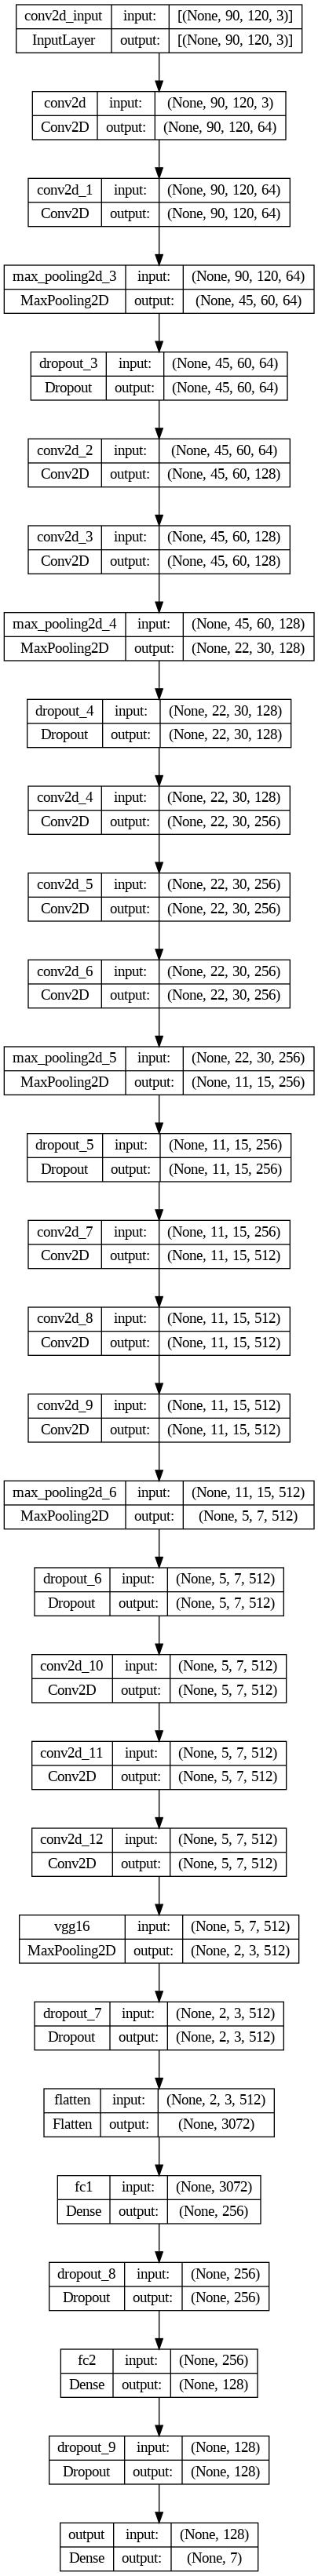

In [ ]:
plot_model(model2, to_file='simple_model_plot2.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='simple_model_plot2.png')

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 120, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 120, 64)       36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 60, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 45, 60, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 60, 128)       147584    
                                                      

In [ ]:
learning_rate_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.000001)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1 
)

epochs = 15
batch_size = 32
model2.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction1])

Epoch 1/15
263/263 [==============================] - 50s 152ms/step - loss: 1.9836 - accuracy: 0.6660 - val_loss: 1.3259 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 2/15
263/263 [==============================] - 37s 140ms/step - loss: 1.2806 - accuracy: 0.6694 - val_loss: 1.2091 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 3/15
263/263 [==============================] - 37s 142ms/step - loss: 1.2009 - accuracy: 0.6695 - val_loss: 1.1736 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 4/15
263/263 [==============================] - 37s 140ms/step - loss: 1.1781 - accuracy: 0.6694 - val_loss: 1.1493 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 5/15
263/263 [==============================] - 36s 135ms/step - loss: 1.1645 - accuracy: 0.6695 - val_loss: 1.1411 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 6/15
263/263 [==============================] - 38s 144ms/step - loss: 1.1551 - accuracy: 0.6690 - val_loss: 1.1364 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 7/15
263/263 [==============================] 

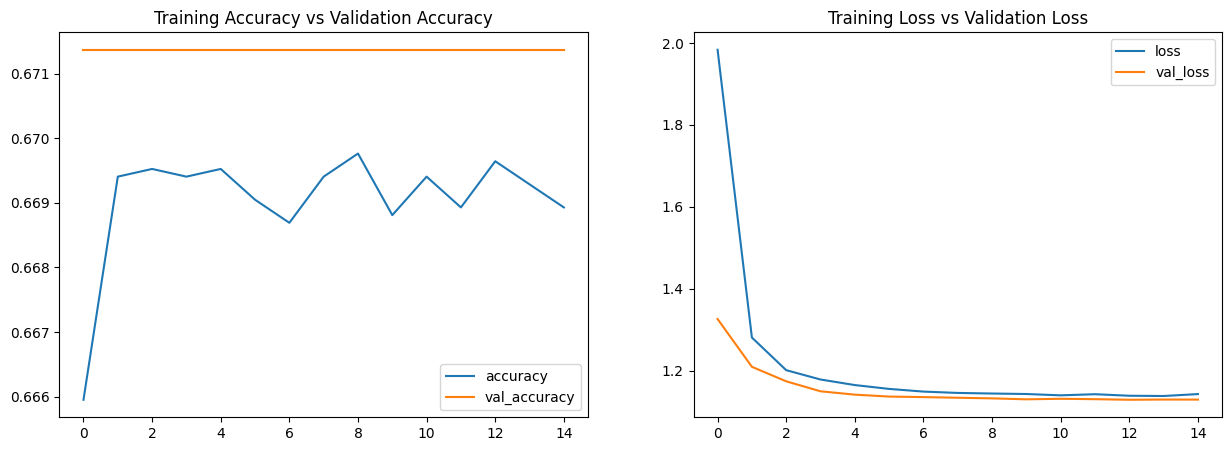

In [ ]:
plot_(model2.history)

MAXIMUM ACCURACY OF VGG16 is :  67.1371
4/4 [==============================] - 1s 188ms/step


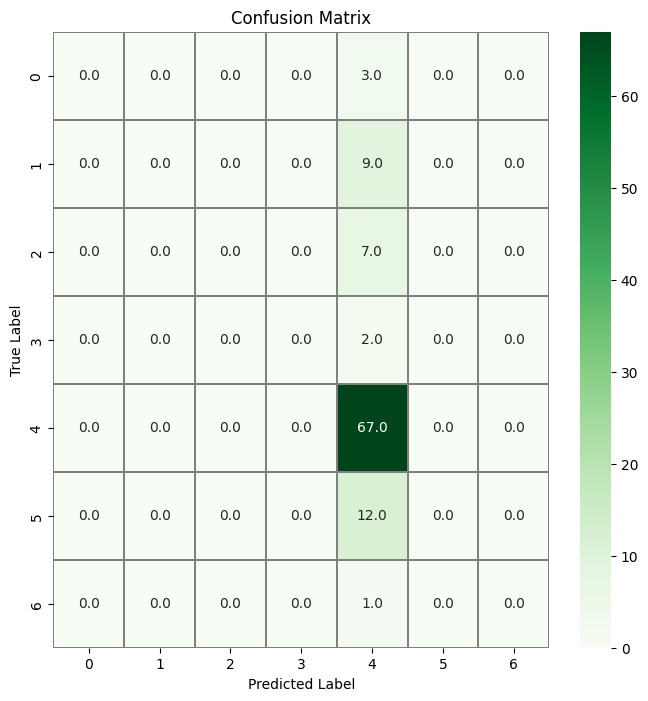

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         2
           4       0.66      1.00      0.80        67
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         1

    accuracy                           0.66       101
   macro avg       0.09      0.14      0.11       101
weighted avg       0.44      0.66      0.53       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("MAXIMUM ACCURACY OF VGG16 is : ", round(max(model2.history.history['val_accuracy'])*100,4))
report(model2)
